In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import json
import mlp.data_providers as data_providers
from pytorch_mlp_framework.model_architectures import *
from pytorch_mlp_framework.model_architectures_dm import ( ConvolutionalProcessingBlockDM, ConvolutionalReductionBlockDM )

In [2]:
!ls
!touch __init__.py



MLP2022_23_CW2_Spec.pdf       mlp-cw2-template.log
README.md		      notebooks
V88_08_experiment	      notes
VGG_08			      pytest.ini
VGG_08_experiment	      pytorch_mlp_framework
VGG_38			      report
VGG_38_experiment	      report.zip
VGG_38_experiment_batch_norm  requirements.txt
__init__.py		      run_vgg_08_default.sh
data			      run_vgg_38_default.sh
gradP.png		      scripts
grad_flow.png		      setup.py
grad_flow_38.pdf	      test_connect.ipynb
install.sh		      test_network
mlp			      vgg_38.json
mlp-cw2-template.aux	      vgg_38_gradients.json
mlp-cw2-template.dvi	      vgg_38_out.pdf
mlp-cw2-template.fdb_latexmk  vgg_38_out.png
mlp-cw2-template.fls


In [3]:
class Arguments:
    batch_size = 100
    continue_from_epoch = -1
    seed = 0
    image_num_channels = 3
    image_height = 32
    image_width = 32
    num_stages = 3
    num_blocks_per_stage = 8
    num_filters = 32
    num_epochs = 1
    num_classes = 100
    experiment_name = 'VGG_08_experiment'
    use_gpu = True
    weight_decay_coefficient = 0
    block_type = 'conv_block'

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import os
import numpy as np
import time
from datetime import datetime
from pytorch_mlp_framework.storage_utils import save_statistics
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 8})

class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()


        self.experiment_name = experiment_name
        self.model = network_model

        if torch.cuda.device_count() > 1 and use_gpu:
            self.device = torch.cuda.current_device()
            self.model.to(self.device)
            self.model = nn.DataParallel(module=self.model)
            print('Use Multi GPU', self.device)
        elif torch.cuda.device_count() == 1 and use_gpu:
            self.device =  torch.cuda.current_device()
            self.model.to(self.device)  # sends the model from the cpu to the gpu
            print('Use GPU', self.device)
        else:
            print("use CPU")
            self.device = torch.device('cpu')  # sets the device to be CPU
            print(self.device)

        print('here')

        self.model.reset_parameters()  # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.all_gradients = []

        print('System learnable parameters')
        num_conv_layers = 0
        num_linear_layers = 0
        total_num_parameters = 0
        for name, value in self.named_parameters():
            print(name, value.shape)
            if all(item in name for item in ['conv', 'weight']):
                num_conv_layers += 1
            if all(item in name for item in ['linear', 'weight']):
                num_linear_layers += 1
            total_num_parameters += np.prod(value.shape)

        print('Total number of parameters', total_num_parameters)
        print('Total number of conv layers', num_conv_layers)
        print('Total number of linear layers', num_linear_layers)

        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        self.learning_rate_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer,
                                                                            T_max=num_epochs,
                                                                            eta_min=0.00002)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.

        if not os.path.exists(self.experiment_folder):  # If experiment directory does not exist
            os.mkdir(self.experiment_folder)  # create the experiment directory
            os.mkdir(self.experiment_logs)  # create the experiment log directory
            os.mkdir(self.experiment_saved_models)  # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device)  # send the loss computation to the GPU

        if continue_from_epoch == -2:  # if continue from epoch is -2 then continue from latest saved model
            self.state, self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx='latest')  # reload existing model from epoch and return best val model index
            # and the best val acc of that model
            self.starting_epoch = int(self.state['model_epoch'])

        elif continue_from_epoch > -1:  # if continue from epoch is greater than -1 then
            self.state, self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch)  # reload existing model from epoch and return best val model index
            # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.state = dict()
            self.starting_epoch = 0

    def get_num_parameters(self):
        total_num_params = 0
        for param in self.parameters():
            total_num_params += np.prod(param.shape)

        return total_num_params


    def plot_func_def(self,all_grads, layers):
        
       
        """
        Plot function definition to plot the average gradient with respect to the number of layers in the given model
        :param all_grads: Gradients wrt weights for each layer in the model.
        :param layers: Layer names corresponding to the model parameters
        :return: plot for gradient flow
        """
        plt.plot(all_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(all_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(all_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(all_grads))
        plt.xlabel("Layers")
        plt.ylabel("Average Gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.tight_layout()
        
        return plt
        
    
    def plot_grad_flow(self, named_parameters):
        """
        The function is being called in Line 298 of this file. 
        Receives the parameters of the model being trained. Returns plot of gradient flow for the given model parameters.
       
        """
        all_grads = []
        layers = []

        for name, p in named_parameters:
            if (p.requires_grad) and ("bias" not in name):
                name = name.replace("layer_dict.", "")
                name = name.replace(".weight", "")
                layers.append(name)
                all_grads.append(p.grad.abs().mean().cpu().numpy())
        """
        Complete the code in the block below to collect absolute mean of the gradients for each layer in all_grads with the             layer names in layers.
        """
        ########################################
        
        
        ########################################
            
        
        plt = self.plot_func_def(all_grads, layers)
        
        return plt, all_grads, layers
    
    
    
    
    def run_train_iter(self, x, y):
        
        self.train()  # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        x, y = x.float().to(device=self.device), y.long().to(
            device=self.device)  # send data to device as torch tensors
        out = self.model.forward(x)  # forward the data in the model


        loss = F.cross_entropy(input=out, target=y)  # compute loss

        self.optimizer.zero_grad()  # set all weight grads from previous training iters to 0
        loss.backward()  # backpropagate to compute gradients for current iter loss
        
        self.learning_rate_scheduler.step(epoch=self.current_epoch)
        self.optimizer.step()  # update network parameters
        _, predicted = torch.max(out.data, 1)  # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
        return loss.cpu().data.numpy(), accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval()  # sets the system to validation mode
        x, y = x.float().to(device=self.device), y.long().to(
            device=self.device)  # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x)  # forward the data in the model

        loss = F.cross_entropy(input=out, target=y)  # compute loss

        _, predicted = torch.max(out.data, 1)  # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
        return loss.cpu().data.numpy(), accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        self.state['network'] = self.state_dict()  # save network parameter and other variables.
        self.state['best_val_model_idx'] = best_validation_model_idx  # save current best val idx
        self.state['best_val_model_acc'] = best_validation_model_acc  # save current best val acc
        torch.save(self.state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(
            model_idx))))  # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state, state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        from datetime import datetime
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [],
                        "val_loss": []}  # initialize a dict to keep the per-epoch metrics
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # get current time
        train_summary_file = f'{self.experiment_name}_{current_time}_train_summary.csv'  # create a filename for the train summary
        val_summary_file = f'{self.experiment_name}_{current_time}_val_summary.csv'  # create a filename for the val summary
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}
            self.current_epoch = epoch_idx
            with tqdm.tqdm(total=len(self.train_data)) as pbar_train:  # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data):  # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y)  # take a training iter step
                    current_epoch_losses["train_loss"].append(loss)  # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy)  # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=len(self.val_data)) as pbar_val:  # create a progress bar for validation
                for x, y in self.val_data:  # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y)  # run a validation iter
                    current_epoch_losses["val_loss"].append(loss)  # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy)  # add current iter acc to val acc lst.
                    pbar_val.update(1)  # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))
            val_mean_accuracy = np.mean(current_epoch_losses['val_acc'])
            if val_mean_accuracy > self.best_val_model_acc:  # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = val_mean_accuracy  # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx  # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(
                    value))  # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename=train_summary_file,
                            stats_dict=total_losses, current_epoch=i,
                            continue_from_mode=True if (self.starting_epoch != 0 or i > 0) else False)  # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(
                ["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time  # calculate time taken for epoch
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            self.state['model_epoch'] = epoch_idx
            self.save_model(model_save_dir=self.experiment_saved_models,
                            # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)
            self.save_model(model_save_dir=self.experiment_saved_models,
                            # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx='latest',
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)
            
            ################################################################
            ##### Plot Gradient Flow at each Epoch during Training  ######
            print("Generating Gradient Flow Plot at epoch {}".format(epoch_idx))
            gradient_plt, gradients, layers = self.plot_grad_flow(self.model.named_parameters())
            self.all_gradients.append(
                {
                    "epoch": epoch_idx,
                    "gradients": gradients,
                    "layers": layers
                }
            )
            if not os.path.exists(os.path.join(self.experiment_saved_models, 'gradient_flow_plots')):
                os.mkdir(os.path.join(self.experiment_saved_models, 'gradient_flow_plots'))
                plt.legend(loc="best")

            print('Saving Gradient Flow Plot at epoch {}'.format(epoch_idx))
            gradient_plt.savefig(
                os.path.join(self.experiment_saved_models, 'gradient_flow_plots', "epoch{}.png".format(str(epoch_idx))), 
                dpi=600
            )
            ################################################################
        
        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx,
                        # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []}  # initialize a statistics dict
        with tqdm.tqdm(total=len(self.test_data)) as pbar_test:  # ini a progress bar
            for x, y in self.test_data:  # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x,
                                                          y=y)  # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss)  # save test loss
                current_epoch_losses["test_acc"].append(accuracy)  # save test accuracy
                pbar_test.update(1)  # update progress bar status
                pbar_test.set_description(
                    "loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output
        test_losses = {key: [np.mean(value)] for key, value in
                       current_epoch_losses.items()}  # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename=val_summary_file,
                        # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0, continue_from_mode=False)

        return total_losses, test_losses, gradient_plt, self.all_gradients


In [34]:
def train_eval_classification_system(args):

    # print all arguments with their values
    rng = np.random.RandomState(seed=args.seed)  # set the seeds for the experiment
    torch.manual_seed(seed=args.seed)  # sets pytorch's seed

# # set up data augmentation transforms for training and testing
    transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_data = data_providers.CIFAR100(root='data', set_name='train',
                 transform=transform_train,
                 download=True)  # initialize our rngs using the argument set seed
    val_data = data_providers.CIFAR100(root='data', set_name='val',
                 transform=transform_test,
                 download=True)  # initialize our rngs using the argument set seed
    test_data = data_providers.CIFAR100(root='data', set_name='test',
                 transform=transform_test,
                 download=True)  # initialize our rngs using the argument set seed

    train_data_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=4)
    val_data_loader = DataLoader(val_data, batch_size=args.batch_size, shuffle=True, num_workers=4)
    test_data_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=True, num_workers=4)

    if args.block_type == 'conv_block':
        processing_block_type = ConvolutionalProcessingBlock
        dim_reduction_block_type = ConvolutionalDimensionalityReductionBlock
    elif args.block_type == 'batchnorm_block':
        processing_block_type = ConvolutionalProcessingBlockDM
        dim_reduction_block_type = ConvolutionalReductionBlockDM
    elif args.block_type == 'empty_block':
        processing_block_type = EmptyBlock
        dim_reduction_block_type = EmptyBlock
    else:
        raise ModuleNotFoundError

    custom_conv_net = ConvolutionalNetwork(
        input_shape=(
            args.batch_size, args.image_num_channels, args.image_height, args.image_width),
        num_output_classes=args.num_classes, num_filters=args.num_filters, use_bias=False,
        num_blocks_per_stage=args.num_blocks_per_stage, num_stages=args.num_stages,
        processing_block_type=processing_block_type,
        dimensionality_reduction_block_type=dim_reduction_block_type)

    print('Setup conv net')

    conv_experiment = ExperimentBuilder(
        network_model=custom_conv_net,
        experiment_name=args.experiment_name,
        num_epochs=args.num_epochs,
        weight_decay_coefficient=args.weight_decay_coefficient,
        use_gpu=args.use_gpu,
        continue_from_epoch=args.continue_from_epoch,
        train_data=train_data_loader, val_data=val_data_loader,
        test_data=test_data_loader
    )

    print('Experiment setup')
    return conv_experiment

In [50]:
# run for vgg 38

def vgg_38_args():
    args = Arguments
    args.num_epochs= 100
    args.num_stages = 3
    args.num_blocks_per_stage = 5
    args.batch_size = 100
    args.experiment_name = "VGG_38_experiment"
    return args

def vgg_08_args():
    args = Arguments
    args.num_epochs= 2
    args.num_stages = 3
    args.num_blocks_per_stage = 0
    args.batch_size = 100
    args.experiment_name = "VGG_08_experiment"
    return args

def vgg_38_batch_norm():
    args = vgg_38_args()
    args.experiment_name = "VGG_38_experiment_batch_norm"
    args.block_type = 'batchnorm_block'
    return args

In [52]:
args = vgg_38_batch_norm()
args.__dict__
conv_experiment = train_eval_classification_system(args)


Files already downloaded and verified
train (47500, 32, 32, 3)
train (47500,)
Files already downloaded and verified
val (2500, 32, 32, 3)
val (2500,)
Files already downloaded and verified
test (10000, 32, 32, 3)
test (10000,)
Building basic block of ConvolutionalNetwork using input shape (100, 3, 32, 32)
torch.Size([100, 32, 32, 32])
shape before final linear layer torch.Size([100, 32, 1, 1])
Block is built, output volume is torch.Size([100, 100])
Setup conv net
Use GPU 0
here
System learnable parameters
model.layer_dict.input_conv.layer_dict.conv_0.weight torch.Size([32, 3, 3, 3])
model.layer_dict.input_conv.layer_dict.bn_0.weight torch.Size([32])
model.layer_dict.input_conv.layer_dict.bn_0.bias torch.Size([32])
model.layer_dict.block_0_0.layer_dict.conv1.weight torch.Size([32, 32, 3, 3])
model.layer_dict.block_0_0.layer_dict.batch_norm1.weight torch.Size([32])
model.layer_dict.block_0_0.layer_dict.batch_norm1.bias torch.Size([32])
model.layer_dict.block_0_0.layer_dict.conv2.weight to

loss: 2.2492, accuracy: 0.4200: 100%|██████████| 25/25 [00:00<00:00, 42.43it/s]


Epoch 0: train_acc_0.4572_train_loss_1.9793_val_acc_0.4100_val_loss_2.2606 epoch time 12.7366 seconds
Generating Gradient Flow Plot at epoch 0
Saving Gradient Flow Plot at epoch 0


loss: 2.0218, accuracy: 0.4200: 100%|██████████| 25/25 [00:00<00:00, 40.00it/s]


Epoch 1: train_acc_0.4567_train_loss_1.9733_val_acc_0.3944_val_loss_2.3250 epoch time 12.8725 seconds
Generating Gradient Flow Plot at epoch 1
Saving Gradient Flow Plot at epoch 1


loss: 2.9491, accuracy: 0.2900: 100%|██████████| 25/25 [00:00<00:00, 38.74it/s]


Epoch 2: train_acc_0.4636_train_loss_1.9574_val_acc_0.3808_val_loss_2.4034 epoch time 12.9830 seconds
Generating Gradient Flow Plot at epoch 2
Saving Gradient Flow Plot at epoch 2


loss: 2.2553, accuracy: 0.4300: 100%|██████████| 25/25 [00:00<00:00, 41.45it/s]


Epoch 3: train_acc_0.4636_train_loss_1.9493_val_acc_0.4168_val_loss_2.1811 epoch time 13.0594 seconds
Generating Gradient Flow Plot at epoch 3
Saving Gradient Flow Plot at epoch 3


loss: 1.9909, accuracy: 0.5000: 100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Epoch 4: train_acc_0.4678_train_loss_1.9336_val_acc_0.4044_val_loss_2.2813 epoch time 12.8775 seconds
Generating Gradient Flow Plot at epoch 4
Saving Gradient Flow Plot at epoch 4


loss: 2.2107, accuracy: 0.3800: 100%|██████████| 25/25 [00:00<00:00, 42.43it/s]


Epoch 5: train_acc_0.4708_train_loss_1.9310_val_acc_0.4160_val_loss_2.1806 epoch time 12.7277 seconds
Generating Gradient Flow Plot at epoch 5
Saving Gradient Flow Plot at epoch 5


loss: 2.1718, accuracy: 0.4200: 100%|██████████| 25/25 [00:00<00:00, 40.43it/s]


Epoch 6: train_acc_0.4756_train_loss_1.9081_val_acc_0.4244_val_loss_2.2126 epoch time 12.8618 seconds
Generating Gradient Flow Plot at epoch 6
Saving Gradient Flow Plot at epoch 6


loss: 1.9289, accuracy: 0.4800: 100%|██████████| 25/25 [00:00<00:00, 41.02it/s]


Epoch 7: train_acc_0.4744_train_loss_1.9033_val_acc_0.4336_val_loss_2.1711 epoch time 12.7597 seconds
Generating Gradient Flow Plot at epoch 7
Saving Gradient Flow Plot at epoch 7


loss: 2.1961, accuracy: 0.4900: 100%|██████████| 25/25 [00:00<00:00, 38.89it/s]


Epoch 8: train_acc_0.4792_train_loss_1.8922_val_acc_0.4300_val_loss_2.1210 epoch time 12.9575 seconds
Generating Gradient Flow Plot at epoch 8
Saving Gradient Flow Plot at epoch 8


loss: 2.2360, accuracy: 0.4900: 100%|██████████| 25/25 [00:00<00:00, 41.48it/s]


Epoch 9: train_acc_0.4822_train_loss_1.8731_val_acc_0.4176_val_loss_2.2458 epoch time 12.7924 seconds
Generating Gradient Flow Plot at epoch 9
Saving Gradient Flow Plot at epoch 9


loss: 1.7173, accuracy: 0.5200: 100%|██████████| 25/25 [00:00<00:00, 41.32it/s]


Epoch 10: train_acc_0.4856_train_loss_1.8614_val_acc_0.4264_val_loss_2.1784 epoch time 12.8272 seconds
Generating Gradient Flow Plot at epoch 10
Saving Gradient Flow Plot at epoch 10


loss: 2.0981, accuracy: 0.4600: 100%|██████████| 25/25 [00:00<00:00, 41.37it/s]


Epoch 11: train_acc_0.4860_train_loss_1.8577_val_acc_0.4316_val_loss_2.1247 epoch time 12.8030 seconds
Generating Gradient Flow Plot at epoch 11
Saving Gradient Flow Plot at epoch 11


loss: 2.0001, accuracy: 0.4400: 100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Epoch 12: train_acc_0.4889_train_loss_1.8364_val_acc_0.4316_val_loss_2.1447 epoch time 13.0970 seconds
Generating Gradient Flow Plot at epoch 12
Saving Gradient Flow Plot at epoch 12


loss: 2.3562, accuracy: 0.3800: 100%|██████████| 25/25 [00:00<00:00, 39.34it/s]


Epoch 13: train_acc_0.4923_train_loss_1.8232_val_acc_0.4372_val_loss_2.1174 epoch time 12.8080 seconds
Generating Gradient Flow Plot at epoch 13
Saving Gradient Flow Plot at epoch 13


loss: 2.1829, accuracy: 0.4800: 100%|██████████| 25/25 [00:00<00:00, 40.66it/s]


Epoch 14: train_acc_0.4938_train_loss_1.8125_val_acc_0.4496_val_loss_2.1221 epoch time 12.7689 seconds
Generating Gradient Flow Plot at epoch 14
Saving Gradient Flow Plot at epoch 14


loss: 1.8667, accuracy: 0.5700: 100%|██████████| 25/25 [00:00<00:00, 39.37it/s]


Epoch 15: train_acc_0.4974_train_loss_1.8014_val_acc_0.4396_val_loss_2.0905 epoch time 13.2290 seconds
Generating Gradient Flow Plot at epoch 15
Saving Gradient Flow Plot at epoch 15


loss: 1.8673, accuracy: 0.5100: 100%|██████████| 25/25 [00:00<00:00, 42.28it/s]


Epoch 16: train_acc_0.5021_train_loss_1.7800_val_acc_0.4332_val_loss_2.1319 epoch time 12.8313 seconds
Generating Gradient Flow Plot at epoch 16
Saving Gradient Flow Plot at epoch 16


loss: 2.0291, accuracy: 0.4600: 100%|██████████| 25/25 [00:00<00:00, 38.95it/s]


Epoch 17: train_acc_0.5034_train_loss_1.7764_val_acc_0.4424_val_loss_2.1168 epoch time 13.0722 seconds
Generating Gradient Flow Plot at epoch 17
Saving Gradient Flow Plot at epoch 17


loss: 1.9147, accuracy: 0.4500: 100%|██████████| 25/25 [00:00<00:00, 41.19it/s]


Epoch 26: train_acc_0.5313_train_loss_1.6597_val_acc_0.4528_val_loss_2.0654 epoch time 12.8938 seconds
Generating Gradient Flow Plot at epoch 26
Saving Gradient Flow Plot at epoch 26


loss: 2.1898, accuracy: 0.4100: 100%|██████████| 25/25 [00:00<00:00, 41.70it/s]


Epoch 27: train_acc_0.5321_train_loss_1.6587_val_acc_0.4652_val_loss_2.0364 epoch time 12.6521 seconds
Generating Gradient Flow Plot at epoch 27
Saving Gradient Flow Plot at epoch 27


loss: 1.9604, accuracy: 0.4100: 100%|██████████| 25/25 [00:00<00:00, 41.87it/s]


Epoch 28: train_acc_0.5364_train_loss_1.6433_val_acc_0.4612_val_loss_2.0201 epoch time 12.7191 seconds
Generating Gradient Flow Plot at epoch 28
Saving Gradient Flow Plot at epoch 28


loss: 1.7668, accuracy: 0.5300: 100%|██████████| 25/25 [00:00<00:00, 39.55it/s]


Epoch 29: train_acc_0.5423_train_loss_1.6201_val_acc_0.4732_val_loss_1.9521 epoch time 12.6833 seconds
Generating Gradient Flow Plot at epoch 29
Saving Gradient Flow Plot at epoch 29


loss: 2.1249, accuracy: 0.4600: 100%|██████████| 25/25 [00:00<00:00, 42.20it/s]


Epoch 30: train_acc_0.5439_train_loss_1.6168_val_acc_0.4636_val_loss_1.9859 epoch time 12.7846 seconds
Generating Gradient Flow Plot at epoch 30
Saving Gradient Flow Plot at epoch 30


loss: 1.7762, accuracy: 0.4900:  55%|█████▌    | 263/475 [00:06<00:05, 41.40it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

loss: 2.0844, accuracy: 0.4600: 100%|██████████| 25/25 [00:00<00:00, 39.75it/s]


Epoch 40: train_acc_0.5705_train_loss_1.5017_val_acc_0.4848_val_loss_1.9695 epoch time 12.4875 seconds
Generating Gradient Flow Plot at epoch 40
Saving Gradient Flow Plot at epoch 40


loss: 1.6200, accuracy: 0.5200: 100%|██████████| 25/25 [00:00<00:00, 38.85it/s]


Epoch 46: train_acc_0.5844_train_loss_1.4423_val_acc_0.4928_val_loss_1.9243 epoch time 12.9483 seconds
Generating Gradient Flow Plot at epoch 46
Saving Gradient Flow Plot at epoch 46


loss: 2.1723, accuracy: 0.4100: 100%|██████████| 25/25 [00:00<00:00, 41.10it/s]


Epoch 47: train_acc_0.5909_train_loss_1.4241_val_acc_0.4948_val_loss_1.9391 epoch time 12.7387 seconds
Generating Gradient Flow Plot at epoch 47
Saving Gradient Flow Plot at epoch 47


loss: 2.0149, accuracy: 0.4800: 100%|██████████| 25/25 [00:00<00:00, 39.69it/s]


Epoch 48: train_acc_0.5950_train_loss_1.4096_val_acc_0.4732_val_loss_2.0560 epoch time 12.5347 seconds
Generating Gradient Flow Plot at epoch 48
Saving Gradient Flow Plot at epoch 48


loss: 1.8737, accuracy: 0.5200: 100%|██████████| 25/25 [00:00<00:00, 39.48it/s]


Epoch 49: train_acc_0.5911_train_loss_1.4066_val_acc_0.4960_val_loss_1.9101 epoch time 13.1158 seconds
Generating Gradient Flow Plot at epoch 49
Saving Gradient Flow Plot at epoch 49


loss: 1.7723, accuracy: 0.4600: 100%|██████████| 25/25 [00:00<00:00, 40.38it/s]


Epoch 50: train_acc_0.5970_train_loss_1.3957_val_acc_0.4936_val_loss_1.9160 epoch time 12.8637 seconds
Generating Gradient Flow Plot at epoch 50
Saving Gradient Flow Plot at epoch 50


loss: 1.5318, accuracy: 0.5600:   3%|▎         | 13/475 [00:00<00:17, 26.89it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

loss: 1.7466, accuracy: 0.5300: 100%|██████████| 25/25 [00:00<00:00, 41.19it/s]


Epoch 72: train_acc_0.6465_train_loss_1.2007_val_acc_0.5168_val_loss_1.8792 epoch time 13.1891 seconds
Generating Gradient Flow Plot at epoch 72
Saving Gradient Flow Plot at epoch 72


loss: 1.6857, accuracy: 0.5500: 100%|██████████| 25/25 [00:00<00:00, 41.20it/s]


Epoch 73: train_acc_0.6487_train_loss_1.1867_val_acc_0.5196_val_loss_1.8837 epoch time 12.5325 seconds
Generating Gradient Flow Plot at epoch 73
Saving Gradient Flow Plot at epoch 73


loss: 2.2852, accuracy: 0.4800: 100%|██████████| 25/25 [00:00<00:00, 39.39it/s]


Epoch 74: train_acc_0.6506_train_loss_1.1852_val_acc_0.5148_val_loss_1.8708 epoch time 12.8905 seconds
Generating Gradient Flow Plot at epoch 74
Saving Gradient Flow Plot at epoch 74


loss: 2.2906, accuracy: 0.4400: 100%|██████████| 25/25 [00:00<00:00, 40.49it/s]


Epoch 75: train_acc_0.6515_train_loss_1.1759_val_acc_0.5220_val_loss_1.8810 epoch time 13.6871 seconds
Generating Gradient Flow Plot at epoch 75
Saving Gradient Flow Plot at epoch 75


loss: 1.8488, accuracy: 0.5200: 100%|██████████| 25/25 [00:00<00:00, 38.06it/s]


Epoch 76: train_acc_0.6543_train_loss_1.1713_val_acc_0.5184_val_loss_1.8892 epoch time 12.9250 seconds
Generating Gradient Flow Plot at epoch 76
Saving Gradient Flow Plot at epoch 76


loss: 1.0195, accuracy: 0.7000:  16%|█▌        | 77/475 [00:02<00:09, 40.71it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

loss: 1.6025, accuracy: 0.5700: 100%|██████████| 25/25 [00:00<00:00, 39.22it/s]


Epoch 96: train_acc_0.6727_train_loss_1.0994_val_acc_0.5304_val_loss_1.8792 epoch time 12.9451 seconds
Generating Gradient Flow Plot at epoch 96
Saving Gradient Flow Plot at epoch 96


loss: 2.0026, accuracy: 0.5400: 100%|██████████| 25/25 [00:00<00:00, 40.33it/s]


Epoch 97: train_acc_0.6709_train_loss_1.1033_val_acc_0.5256_val_loss_1.8835 epoch time 12.8173 seconds
Generating Gradient Flow Plot at epoch 97
Saving Gradient Flow Plot at epoch 97


loss: 1.7034, accuracy: 0.6000: 100%|██████████| 25/25 [00:00<00:00, 40.06it/s]


Epoch 98: train_acc_0.6709_train_loss_1.1029_val_acc_0.5296_val_loss_1.8824 epoch time 12.8757 seconds
Generating Gradient Flow Plot at epoch 98
Saving Gradient Flow Plot at epoch 98


loss: 1.5020, accuracy: 0.5500: 100%|██████████| 25/25 [00:00<00:00, 41.63it/s]


Epoch 99: train_acc_0.6709_train_loss_1.0983_val_acc_0.5264_val_loss_1.8871 epoch time 12.8821 seconds
Generating Gradient Flow Plot at epoch 99
Saving Gradient Flow Plot at epoch 99
Generating test set evaluation metrics


loss: 1.8368, accuracy: 0.4800: 100%|██████████| 100/100 [00:01<00:00, 73.88it/s] 


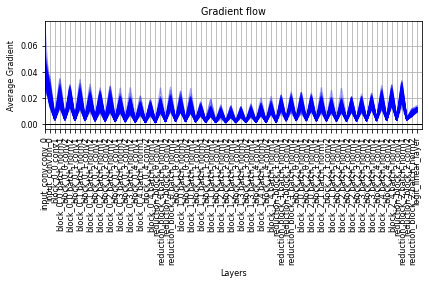

In [54]:
train_loss, test_loss, gradient_plt, all_gradients = conv_experiment.run_experiment()


In [14]:
all_gradients[0].keys()

layers = all_gradients[0]['layers']

output_dict = {}
output_dict['layers'] = layers
for grad in  all_gradients:
    gradient_deserialzied = [float(grad) for grad in grad['gradients']]
    output_dict[f'epoch_{grad["epoch"]}'] = gradient_deserialzied

In [15]:
from datetime import datetime
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

with open('vgg_38_batch_norm.json', 'w') as fp:
    json.dump(output_dict, fp)